In [2]:
## Load model
import pickle

# Function to load model from pickle file
def load_model_pickle(path="vap_model.pkl"):
    with open(path, "rb") as f:
        model = pickle.load(f)
    model.eval()
    print("Model loaded successfully from pickle file!")
    return model

In [3]:
import torch
import torch.nn as nn

# VAP Model forward propogation --> needs to initialize this to load model
class VAPModel(nn.Module):
    def __init__(self, input_dim=40, hidden_dim=128, num_heads=4, num_layers=2, output_dim=2):
        super(VAPModel, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.transformer(x)
        x = self.fc(x)
        return torch.sigmoid(x)


model = load_model_pickle()

Model loaded successfully from pickle file!


In [ ]:
import pyaudio
import torchaudio.transforms as T
import numpy as np

# Real-time inference from microphone
def infer_from_mic(model, sample_rate=16000, chunk_size=1024):
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16, channels=1, rate=sample_rate, input=True, frames_per_buffer=chunk_size)
    mfcc_transform = T.MFCC(sample_rate=sample_rate, n_mfcc=40, 
                            melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40})
    print("Listening...")
    
    try:
        while True:
            audio_data = stream.read(chunk_size)
            waveform = torch.from_numpy(np.frombuffer(audio_data, dtype=np.int16).astype(np.float32) / 32768.0).unsqueeze(0)
            mfcc = mfcc_transform(waveform).squeeze(0).T.unsqueeze(0)  # Add batch dimension
            with torch.no_grad():
                output = model(mfcc)
                prediction = output.squeeze(0).cpu().numpy()
                print("Prediction:", prediction)
    except KeyboardInterrupt:
        print("Stopping...")
        stream.stop_stream()
        stream.close()
        p.terminate()

# Load trained model and run inference
model = load_model_pickle()
infer_from_mic(model)

Model loaded successfully from pickle file!
Listening...
Prediction: [[0.48075905 0.47072354]
 [0.48098227 0.47107   ]
 [0.47835934 0.4702787 ]
 [0.47656915 0.46914735]
 [0.4773721  0.46910253]
 [0.47860962 0.4696647 ]
 [0.47996065 0.46978486]]
Prediction: [[0.48120937 0.47055942]
 [0.48024663 0.46897185]
 [0.48080844 0.46917364]
 [0.4810833  0.47031227]
 [0.48120698 0.47050986]
 [0.4816829  0.4713412 ]
 [0.48131335 0.46982273]]
Prediction: [[0.4820311  0.47200453]
 [0.4831145  0.47240803]
 [0.48263198 0.47142848]
 [0.48306865 0.47221658]
 [0.48314026 0.4722717 ]
 [0.48257372 0.47265056]
 [0.481376   0.47184333]]
Prediction: [[0.48114178 0.47071013]
 [0.4832171  0.47335485]
 [0.4827084  0.47213694]
 [0.48365724 0.47306478]
 [0.48419067 0.47327307]
 [0.48388198 0.47199434]
 [0.48307517 0.47145543]]
Prediction: [[0.48069233 0.46775502]
 [0.48349667 0.47116858]
 [0.48455453 0.47277626]
 [0.4878147  0.47564024]
 [0.48674193 0.47443512]
 [0.48585212 0.4738351 ]
 [0.48643768 0.4750057 ]]
Pre

In [ ]:
import pyaudio
import torch
import torchaudio.transforms as T
import numpy as np

# Real-time inference from microphone, streaming to a function
def infer_from_mic_stream(model, callback_function, sample_rate=16000, chunk_size=1024):
    """
    Streams microphone audio to a callback function for real-time inference.

    Args:
        model: The PyTorch model for inference.
        callback_function: A function that will receive the model's prediction.
        sample_rate: The audio sample rate.
        chunk_size: The size of audio chunks to process.
    """
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16, channels=1, rate=sample_rate, input=True, frames_per_buffer=chunk_size)
    mfcc_transform = T.MFCC(sample_rate=sample_rate, n_mfcc=40,
                            melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40})

    try:
        while True:
            audio_data = stream.read(chunk_size)
            waveform = torch.from_numpy(np.frombuffer(audio_data, dtype=np.int16).astype(np.float32) / 32768.0).unsqueeze(0)
            mfcc = mfcc_transform(waveform).squeeze(0).T.unsqueeze(0)  # Add batch dimension
            with torch.no_grad():
                output = model(mfcc)
                prediction = output.squeeze(0).cpu().numpy()
                array = np.array(prediction)
                mean = np.mean(array, axis=0)
                avg = mean[1].item()
                # print(prediction)
                callback_function(avg)  # Call the provided function with the prediction

    except KeyboardInterrupt:
        stream.stop_stream()
        stream.close()
        p.terminate()


Data:  [0.473886102437973, 0.47298797965049744, 0.4753364026546478, 0.472940057516098, 0.47374939918518066, 0.47347304224967957, 0.47428879141807556, 0.4743006229400635, 0.4741334915161133, 0.4718548655509949, 0.4720010757446289, 0.47260841727256775, 0.4720098376274109, 0.4791528880596161, 0.4753495752811432, 0.4735885262489319, 0.47854262590408325, 0.4764087200164795, 0.4762537181377411, 0.47398900985717773, 0.4745844304561615, 0.4755134880542755, 0.4771197736263275, 0.47759318351745605, 0.4749104976654053, 0.4726697504520416, 0.4728338122367859, 0.471459299325943, 0.4711858332157135, 0.47123008966445923, 0.4757077395915985, 0.47370603680610657, 0.4732326567173004, 0.4782979190349579, 0.4725897014141083, 0.47371959686279297, 0.4770784378051758, 0.4772028625011444, 0.47739917039871216, 0.4760773181915283, 0.4719453454017639, 0.473708838224411, 0.47475650906562805, 0.4765881597995758, 0.47419556975364685, 0.47250622510910034, 0.4716172516345978, 0.47205522656440735, 0.47327345609664917,

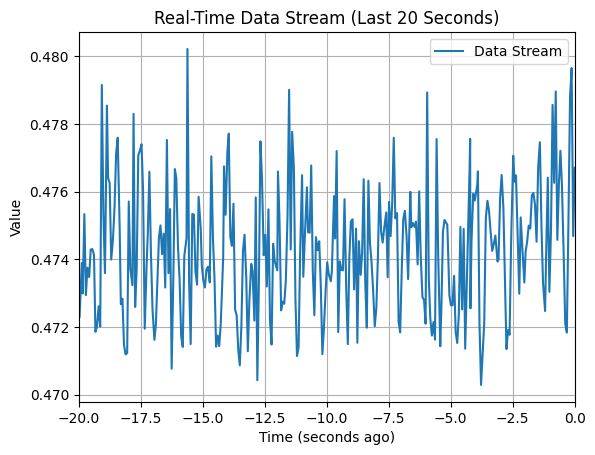

Data:  [0.4753364026546478, 0.472940057516098, 0.47374939918518066, 0.47347304224967957, 0.47428879141807556, 0.4743006229400635, 0.4741334915161133, 0.4718548655509949, 0.4720010757446289, 0.47260841727256775, 0.4720098376274109, 0.4791528880596161, 0.4753495752811432, 0.4735885262489319, 0.47854262590408325, 0.4764087200164795, 0.4762537181377411, 0.47398900985717773, 0.4745844304561615, 0.4755134880542755, 0.4771197736263275, 0.47759318351745605, 0.4749104976654053, 0.4726697504520416, 0.4728338122367859, 0.471459299325943, 0.4711858332157135, 0.47123008966445923, 0.4757077395915985, 0.47370603680610657, 0.4732326567173004, 0.4782979190349579, 0.4725897014141083, 0.47371959686279297, 0.4770784378051758, 0.4772028625011444, 0.47739917039871216, 0.4760773181915283, 0.4719453454017639, 0.473708838224411, 0.47475650906562805, 0.4765881597995758, 0.47419556975364685, 0.47250622510910034, 0.4716172516345978, 0.47205522656440735, 0.47327345609664917, 0.47465091943740845, 0.4749981760978699

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import time
import threading

# Initialize lists to store the data points
max_window_seconds = 20  # Sliding window of 20 seconds
data = []
timestamps = []

# Lock for thread-safe access to shared data
data_lock = threading.Lock()

# Example callback function
def process_prediction_1(prediction):
    # Convert prediction to a NumPy array
    # data_array = np.array(prediction)
    
    # Calculate the column average (ensure it's a scalar or 1D array)
    # column_average = np.mean(data_array, axis=0)
    
    # Append the scalar value to the data list
    current_time = time.time()
    with data_lock:  # Ensure thread-safe access to shared data
        data.append(prediction)  # Use the first element of column_average
        timestamps.append(current_time)
        
        # Remove data points older than the sliding window
        while timestamps and (current_time - timestamps[0]) > max_window_seconds:
            timestamps.pop(0)
            data.pop(0)
    
    # Print for debugging
    print("Data: ", data)
    print("Timestamps: ", timestamps)

# Function to update the plot
def update_plot():
    plt.figure(figsize=(10, 3))
    while True:
        with data_lock:  # Ensure thread-safe access to shared data
            # Calculate relative time for the X-axis (current time - timestamp)
            relative_timestamps = [t - timestamps[-1] for t in timestamps] if timestamps else []
            current_data = data.copy()  # Create a copy of the data for plotting
        
        plt.clf()  # Clear the current figure
        
        # Plot the data
        plt.plot(relative_timestamps, current_data, label='Data Stream')
        plt.xlabel('Time (seconds ago)')
        plt.ylabel('Value')
        plt.title(f'Real-Time Data Stream (Last {max_window_seconds} Seconds)')
        plt.legend()
        plt.grid(True)
        
        # Set X-axis limits to show the last 20 seconds
        plt.xlim(-max_window_seconds, 0)
        
        clear_output(wait=True)  # Clear the previous output
        display(plt.gcf())       # Display the current figure
        
        time.sleep(1)  # Wait for 1 second before updating the plot again

# Start the plot update in a separate thread
plot_thread = threading.Thread(target=update_plot)
plot_thread.daemon = True
plot_thread.start()

# Simulate the streaming function (replace this with your actual streaming function)
def simulate_stream():
    while True:
        # Simulate a prediction (replace this with your actual prediction data)
        # prediction = np.random.rand(5, 3)  # Example: 5x3 array
        infer_from_mic_stream(model, process_prediction_1)
        # process_prediction_1(prediction)
        time.sleep(1)  # Simulate a delay between data points

# Start the streaming function in a separate thread
stream_thread = threading.Thread(target=simulate_stream)
stream_thread.daemon = True
stream_thread.start()

# Keep the main thread alive to allow the other threads to run
while True:
    time.sleep(1)

Data:  [0.47709131240844727, 0.47579139471054077, 0.4742652475833893, 0.47301504015922546, 0.4733302891254425, 0.47463807463645935, 0.4753417670726776, 0.4737078845500946, 0.4725896418094635, 0.4721849858760834, 0.47261837124824524, 0.4743864834308624, 0.4746526777744293, 0.4734601080417633, 0.4740000069141388, 0.4747975170612335, 0.4741835594177246, 0.47553786635398865, 0.4747649133205414, 0.47461920976638794, 0.47514215111732483, 0.47536715865135193, 0.47406643629074097, 0.47342047095298767, 0.47284355759620667, 0.47371265292167664, 0.47483763098716736, 0.4749320447444916, 0.4746290147304535, 0.47444769740104675, 0.47387441992759705, 0.47378021478652954, 0.47422876954078674, 0.4746132493019104, 0.4748910367488861, 0.4749614894390106, 0.476484090089798, 0.47792407870292664, 0.4769494831562042, 0.47528284788131714, 0.4742043912410736, 0.4744257926940918, 0.4734874367713928, 0.4714863896369934, 0.4718397557735443, 0.47256484627723694, 0.472275048494339, 0.4716106951236725, 0.47234389185

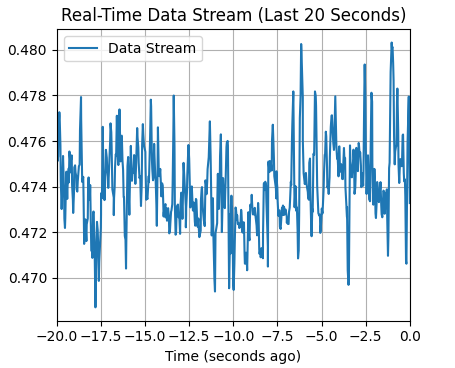

Data:  [0.47301504015922546, 0.4733302891254425, 0.47463807463645935, 0.4753417670726776, 0.4737078845500946, 0.4725896418094635, 0.4721849858760834, 0.47261837124824524, 0.4743864834308624, 0.4746526777744293, 0.4734601080417633, 0.4740000069141388, 0.4747975170612335, 0.4741835594177246, 0.47553786635398865, 0.4747649133205414, 0.47461920976638794, 0.47514215111732483, 0.47536715865135193, 0.47406643629074097, 0.47342047095298767, 0.47284355759620667, 0.47371265292167664, 0.47483763098716736, 0.4749320447444916, 0.4746290147304535, 0.47444769740104675, 0.47387441992759705, 0.47378021478652954, 0.47422876954078674, 0.4746132493019104, 0.4748910367488861, 0.4749614894390106, 0.476484090089798, 0.47792407870292664, 0.4769494831562042, 0.47528284788131714, 0.4742043912410736, 0.4744257926940918, 0.4734874367713928, 0.4714863896369934, 0.4718397557735443, 0.47256484627723694, 0.472275048494339, 0.4716106951236725, 0.47234389185905457, 0.47260400652885437, 0.4739563465118408, 0.47440019249

In [ ]:
import pyaudio
import torch
import torchaudio.transforms as T
import numpy as np

# Real-time inference from microphone, streaming to a function
def infer_from_mic_stream(model, callback_function, sample_rate=16000, chunk_size=1024):
    """
    Streams microphone audio to a callback function for real-time inference.

    Args:
        model: The PyTorch model for inference.
        callback_function: A function that will receive the model's prediction.
        sample_rate: The audio sample rate.
        chunk_size: The size of audio chunks to process.
    """
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16, channels=1, rate=sample_rate, input=True, frames_per_buffer=chunk_size)
    mfcc_transform = T.MFCC(sample_rate=sample_rate, n_mfcc=40,
                            melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40})

    try:
        while True:
            audio_data = stream.read(chunk_size)
            waveform = torch.from_numpy(np.frombuffer(audio_data, dtype=np.int16).astype(np.float32) / 32768.0).unsqueeze(0)
            mfcc = mfcc_transform(waveform).squeeze(0).T.unsqueeze(0)  # Add batch dimension
            with torch.no_grad():
                output = model(mfcc)
                prediction = output.squeeze(0).cpu().numpy()
                array = np.array(prediction)
                mean = np.mean(array, axis=0)
                avg = mean[1].item()
                # print(prediction)
                callback_function(avg)  # Call the provided function with the prediction

    except KeyboardInterrupt:
        stream.stop_stream()
        stream.close()
        p.terminate()




import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import time
import threading

# Initialize lists to store the data points
max_window_seconds = 20  # Sliding window of 20 seconds
data = []
timestamps = []

# Lock for thread-safe access to shared data
data_lock = threading.Lock()


# Example callback function
def process_prediction_1(prediction):
    
    # Append the scalar value to the data list
    current_time = time.time()
    with data_lock:  # Ensure thread-safe access to shared data
        data.append(prediction)  # Use the first element of column_average
        timestamps.append(current_time)
        
        # Remove data points older than the sliding window
        while timestamps and (current_time - timestamps[0]) > max_window_seconds:
            timestamps.pop(0)
            data.pop(0)
    
    # Print for debugging
    print("Data: ", data)
    print("Timestamps: ", timestamps)

# Function to update the plot
def update_plot():
    plt.figure(figsize=(10, 3))
    while True:
        with data_lock:  # Ensure thread-safe access to shared data
            # Calculate relative time for the X-axis (current time - timestamp)
            relative_timestamps = [t - timestamps[-1] for t in timestamps] if timestamps else []
            current_data = data.copy()  # Create a copy of the data for plotting
        
        plt.clf()  # Clear the current figure
        
        # Plot the data
        plt.plot(relative_timestamps, current_data, label='Data Stream')
        plt.xlabel('Time (seconds ago)')
        plt.ylabel('Value')
        plt.title(f'Real-Time Data Stream (Last {max_window_seconds} Seconds)')
        plt.legend()
        plt.grid(True)
        
        # Set X-axis limits to show the last 20 seconds
        plt.xlim(-max_window_seconds, 0)
        
        clear_output(wait=True)  # Clear the previous output
        display(plt.gcf())       # Display the current figure
        
        time.sleep(1)  # Wait for 1 second before updating the plot again

# Start the plot update in a separate thread
plot_thread = threading.Thread(target=update_plot)
plot_thread.daemon = True
plot_thread.start()

# Simulate the streaming function (replace this with your actual streaming function)
def simulate_stream():
    while True:
        # Simulate a prediction (replace this with your actual prediction data)
        # prediction = np.random.rand(5, 3)  # Example: 5x3 array
        infer_from_mic_stream(model, process_prediction_1)
        # process_prediction_1(prediction)
        time.sleep(1)  # Simulate a delay between data points

# Start the streaming function in a separate thread
stream_thread = threading.Thread(target=simulate_stream)
stream_thread.daemon = True
stream_thread.start()

# Keep the main thread alive to allow the other threads to run
while True:
    time.sleep(1)